In [32]:
import sys
sys.path.append('../../')

from scipy.signal import savgol_filter

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from Modules.Utils.Imports import *
from Modules.Utils.DRUMS_Lasso import *
from Modules.Utils.GetLowestGPU import *
import Modules.Loaders.DataFormatter as DF

from Notebooks.utils import get_case_name
from queue import PriorityQueue

In [33]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [34]:
# instantiate BINN model parameters and path
path = '../../Data/covasim_data/drums_data/'

population = int(500e3)
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = 1
multiple = True
parallelb = True
n_runs = 64
chi_type = 'piecewise'

case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)

In [35]:
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingdem'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'

if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

In [36]:
# multiple==True and parallelb==False means that data is a list and not normalized
if multiple and not parallelb:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
    avg_masking = np.mean(params['avg_masking'], axis=0)
    avg_masking = (avg_masking / params['population'])
# multiple==True and parallelb==True means that the data is a 2d array and normalized
elif multiple and parallelb:
    data = params['data'] # parallel simulations store normalized data
    avg_masking = params['avg_masking']
# otherwise, the data is from a single simulation and is not normalized
else:
    data = params['data']
    data = (data / params['population']).to_numpy()
    avg_masking = params['avg_masking']
    avg_masking = (avg_masking / params['avg_masking'])
    
params.pop('data')

N = len(data)
t_max = N - 1
t = np.arange(N)[:,None]

tracing_array = params['tracing_array']

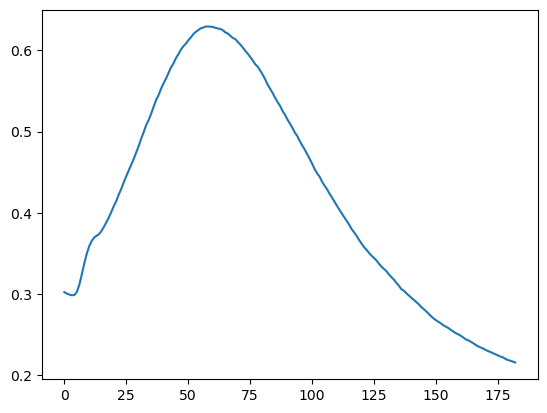

In [37]:
plt.plot(t, avg_masking)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(t, avg_masking)

degree = 12
training_error = []
cross_validation_error = []

best_error = int(1e6)

for d in range(1,degree):
    x_poly_train=PolynomialFeatures(degree=d).fit_transform(x_train) # generate polynomial features up to degree d
    x_poly_test=PolynomialFeatures(degree=d).fit_transform(x_test)
    
    lr=LinearRegression(fit_intercept=False) # instantiate the linear regression object/model
    model=lr.fit(x_poly_train,y_train) # fit the model
    
    y_train_pred=model.predict(x_poly_train) # save the predicted values of the model for given inputs x_poly_train
    
    mse_train=mean_squared_error(y_train,y_train_pred)
    cve=cross_validate(lr, x_poly_train, y_train, scoring='neg_mean_squared_error', cv=10, return_train_score=True)
    
    training_error.append(mse_train) # save MSE from training
    cross_validation_error.append(np.mean(np.absolute(cve['test_score']))) # save the CV error
    
    if cross_validation_error[d - 1] < best_error:
        best_degree = d
        best_model = model
        best_error = cross_validation_error[d - 1]
    
fig,ax=plt.subplots(figsize=(6,6))
ax.plot(range(1,degree),cross_validation_error)
ax.set_xlabel('Degree',fontsize=20)
ax.set_ylabel('MSE',fontsize=20)
ax.set_title('MSE VS Degree',fontsize=25)
plt.close()

In [39]:
t_poly=PolynomialFeatures(degree=best_degree).fit_transform(t)
plt.plot(t, best_model.predict(t_poly))

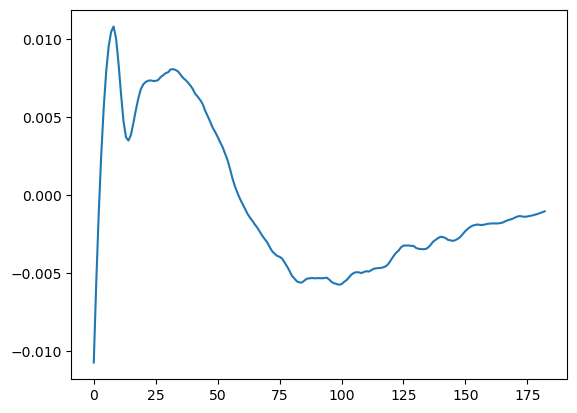

In [40]:
window_size = 15
degree = 3
mt = to_torch(savgol_filter(avg_masking, window_size, degree, deriv=1, axis=0))
plt.plot(t, mt)

In [41]:
comps = list('STEAYDQRF')
X_dict = {key : value for key, value in zip(comps, data.T)}

In [11]:
best_mse = int(1e6)
best_dict = {}
best_alpha = -1

eq_set = set()
eq_q = PriorityQueue()
alphas_list = np.linspace(float(1e-7), float(1e-5), num=5000)

for i in alphas_list:
    lasso_dict = DRUMS_Lasso(X_dict, mt, intercept=False, alphas=np.array([i]))
    if not lasso_dict['Equation'] in eq_set:
        eq_set.add(lasso_dict['Equation'])
        eq_q.put((lasso_dict['MSE'], i, lasso_dict['Equation'], lasso_dict['Lasso']))

c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.641998236233352e-05, tolerance: 2.193356437512983e-07
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010611635284037423, tolerance: 3.5565615102892126e-07
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:620: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.244204914795294e-05, tolerance: 3.1587901679547074e-07
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Teddy\anaconda3\env

In [12]:
good_five = False
while not good_five:
    cand = eq_q.get()
    num_components = len(cand[2].split('+')) - 1
    if num_components <=5:
        good_five = True

five_comp_tuple = cand

good_four = False
while not good_four:
    cand = eq_q.get()
    num_components = len(cand[2].split('+')) - 1
    if num_components <=4:
        good_four = True
        
four_comp_tuple = cand

In [42]:
five_comp_tuple = (five_comp_tuple[0], five_comp_tuple[1], five_comp_tuple[2].replace(' + 0.00000', ''), five_comp_tuple[-1])
four_comp_tuple = (four_comp_tuple[0], four_comp_tuple[1], four_comp_tuple[2].replace(' + 0.00000', ''), four_comp_tuple[-1])
print(five_comp_tuple)
print()
print(four_comp_tuple)

(2.563008456571545e-06, 2.6635327065413083e-07, 'f = -0.43181*T + 2.01445*Y + -0.03746*R + 0.00262*S^2 + -0.00562*S R', LassoCV(alphas=array([2.66353271e-07]), cv=5, fit_intercept=False))

(2.7260988681419853e-06, 3.7527505501100223e-07, 'f = -0.40171*T + 1.78435*Y + -0.04679*R + 0.00317*S^2', LassoCV(alphas=array([3.75275055e-07]), cv=5, fit_intercept=False))


In [30]:
indices = four_comp_tuple[-1].coef_.nonzero()[0][1:]